### Spotipy Workshop

### Step-by-step guide for Part 2
    * Generate a playlist based on your library and recent activity
    * Get ids of the tracks in your playlists (or recently played tracks)
    * Get musical features for those tracks
    * Do clustering of all the tracks in the library by audio features.
    * Get recommendations based on your tracks

        
##### acknoledgements go to https://github.com/smyrbdr/make-your-own-Spotify-playlist-of-playlist-recommendations/blob/master/Make_Your_Own_Playlist_of_Recs-with_PCA%2Btf-idf%2BDT_on_Blues.ipynb

In [1]:
SPOTIPY_CLIENT_ID = "1f4ab19601f042c58b85124ff4b853e2"
SPOTIPY_CLIENT_SECRET = "5ed26d48dcd74f0c9bd9e742d231047b"
SPOTIPY_REDIRECT_URI = 'http://localhost/'
SPOTIFY_USERNAME = "hcuestam"

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

from IPython.display import Image, Audio, display
from IPython.core.display import HTML 

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
scope = 'user-library-read playlist-read-private user-read-recently-played user-top-read playlist-modify-public'

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(SPOTIFY_USERNAME, scope)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print('Check the enviroment variables, the redirect URI and try again')



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?scope=playlist-modify-public+playlist-read-private+user-library-read+user-read-recently-played+user-top-read&redirect_uri=http%3A%2F%2Flocalhost%2F&response_type=code&client_id=cbf03757b58f47d28e86744410160ff6 in your browser


Enter the URL you were redirected to: http://localhost/?code=AQC4bmhb9n3P3QyGYBUFH4c5Bivv9i71NQhPOUqaktLi-GC231FUuF8TfEkarJDKJ5t2i52T8PyVmI9kFGAMlkqxJ0ClW5N7jucOa59ZQAIvS2y6q_bDsKgXNO7A9fUPUp9H4R0_x-P0eoq7QiBfHkPRVGmj5JC23hTqiO0c78CcrYAbeNnOlU4fE_OZyMuwVz4_kbDxZ9C0WcfFOuPtSNDEhLWxf-CLP_9WsHvlE43HKLNO4_WS5nwhoQj_0GjbOFGYLLvRG8u7u_3o7iNrGLzzmvKjWPk_-XJ1IVCvaolH2cL94QKgCf56R-Wtp0bZvu4F




In case you have a lot of playlists, this step may take a lot of time. In this case, you may try to reduce the number of playlists that will be analyzed in the following line:
~~~
for playlist in playlists[:2]:
~~~
where 2 is the number of playlists that will be used.  

In this code cell we take the playlists, remove the local tracks, and extract a set of audio features from each track of the playlists. Spotipy has a built-in function to extract the following audio features:
* Acousticness
* Danceability
* Duration in ms
* Energy
* Instrumentalness
* Key
* Liveness
* Loudness
* Mode
* Speechiness
* Tempo
* Valence

Each of these features is expressed as a number, and they give information about a song.

In [5]:
playlists = sp.current_user_playlists()['items']
playlist_df = list()
tracks = dict()

for playlist in playlists[:2]:
    playlist_data = sp.user_playlist(SPOTIFY_USERNAME, playlist['id'], fields='tracks')['tracks']['items']
    
    for track in playlist_data:
        if track['track']['id']: # Removes the local tracks in your playlist if there is any
            tracks[track['track']['id']] = track['track']['name']

    features = list()
    for track_id in tracks.keys():
        audio_features = sp.audio_features([track_id])
        for track in audio_features:
            features.append(track)

    playlist_df.append(pd.DataFrame(features, index = tracks.keys()))

In [11]:
features_df = pd.concat(playlist_df)
features_df=features_df[["id", "acousticness", "danceability", "duration_ms", 
                         "energy", "instrumentalness",  "key", "liveness",
                         "loudness", "mode", "speechiness", "tempo", "valence"]]
features_df.head()

128


### CLUSTERING

Now that we have the features of our tracks (stored in `features_df`), we want to check how we can group songs according to them. To do so, we will use a **clustering** algorithm, which is a *machine learning* technique that consists of grouping similar data in several **clusters**. We will use a Python library for machine learning called *scikit-learn* and the most basic clustering algorithm called **K-Means**.  

We have several options to cluster our songs:

1. using all the audio features
2. using only one feature (e.g. the tempo)
3. using a subset of the features (e.g. tempo, danceability and liveness)

and we can also try using different numbers of clusters. Depending on the number of clusters we want to create, we will obtain different results.  

To start with an intuitive example, we first use only two features: tempo and danceability, which are more or less related to each other, and two clusters. We would expect the *fast* songs and the *slow* songs to be in separate clusters.  

In the first cell we create a plot to display the two features for each track.

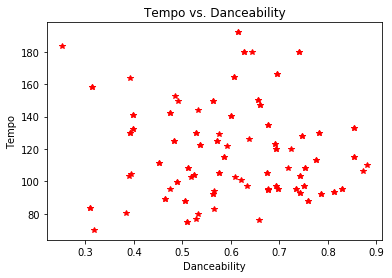

In [25]:
from sklearn.cluster import *
import matplotlib.pyplot as plt

plt.plot(features_df['danceability'],features_df['tempo'],'*r')
plt.title('Tempo vs. Danceability'), plt.xlabel('Danceability'), plt.ylabel('Tempo')
plt.show()

In the plot above we do not find a strong separation between two clusters in terms of the two selected features, but we will see what the algorithm returns.

In [43]:
# this variable should contain the name of the features we will use
keys_to_use = ["danceability","tempo"]

# we will store the ID of each track just in case we need it afterwards
X = np.vstack([features_df[keys_to_use[0]],features_df[keys_to_use[1]],features_df['id']]).transpose()

# run K-Means algorithm on the data
kmeans = KMeans(n_clusters=2).fit(X[:,:-1])

# the algorithm assigns a label (0 or 1) to each song 
kmeans.labels_


array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

Now let's plot the data points (each track) with different colour depending on the assigned cluster.

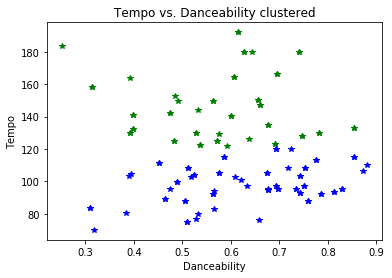

In [53]:
for i in range(len(features_df)):
    if kmeans.labels_[i] == 1:
        plt.plot(features_df['danceability'][i],features_df['tempo'][i],'*b')
    elif kmeans.labels_[i] == 0:
        plt.plot(features_df['danceability'][i],features_df['tempo'][i],'*g')

plt.title('Tempo vs. Danceability clustered'), plt.xlabel('Danceability'), plt.ylabel('Tempo')
plt.show()

In the plot above we clearly see that K-Means divided our songs according to the tempo, since the data is divided vertically. 
Now that we know how the algorithm clusters our data, let's check which tracks belong to each group. For this, we will use the ID we stored afterwards.

In [65]:
idx_cluster_0 = np.where(kmeans.labels_ == 0)[0]
idx_cluster_1 = np.where(kmeans.labels_ == 1)[0]

print("Tracks in cluster 0: ")
# in the last column of X we have the track id
for iden in X[idx_cluster_0,-1]:
    print(tracks[iden])

print("\nTracks in cluster 1: ")
for iden in X[idx_cluster_1,-1]:
    print(tracks[iden])

Tracks in cluster 0: 
La Camisa Negra
Better Run
Voldria que fossis aquí
Amagada Primavera
Fight Song / Amazing Grace
Parole parole
Love For $ale - Live At Abbey Road
Sono qui per te
Sueños De Sirena
(It's Gonna Be) Okay
Tout ce qu'ils veulent (Live at L'Olympia)
Saturn
Picky
Saber Demasiado
Un Estel Fugaç
Sun Bay 2
Avi
Shofukan
Benvinguts
Anyway
Uptown Funk
El Taxi - Radio Edit
Photograph
Alligator Sky
Let Her Go
Besos
Jo joglar
Hey, Soul Sister
La Camisa Negra
Better Run
7 Years
Voldria que fossis aquí
Amagada Primavera
City of Stars
It's Time
Make You Feel My Love
Fight Song / Amazing Grace
Parole parole
Love For $ale - Live At Abbey Road
Sono qui per te
Sueños De Sirena
(It's Gonna Be) Okay
Drive By
Tout ce qu'ils veulent (Live at L'Olympia)
Saturn
Picky
Saber Demasiado
Un Estel Fugaç
Rockabye - Acoustic Version
Maps
La Vie En Rose
I'm Gonna Be (500 Miles)
Sun Bay 2
Safe and sound - feat. Stereo Dub
I Don't Wanna Miss a Thing
Avi
I Will Try
Shofukan
Benvinguts
Anyway
Uptown Funk
To

Go through the lists above and check if the algorithm clustered your songs well according to your perception of the tempo and danceability.  

Try to replicate the same procedure with **other pairs** (or more!) of audio features, and analyze the results. Remember that you can also **change the number of clusters**. Add as many cells as you need for your experiments. We recommend you spend some time adapting the code above to work with other features and different number of clusters. You can also try other playlists (see the code in cells above) to test the algorithm with other songs. Take into account that the type of plots we did with the two example features can only be done if you use a pair of features; if you use more features at the same time (**highly recommended!**), you will not be able to display this plot.

In [ ]:
# YOUR NEW CODE HERE

### RECOMMENDATIONS

Next, we will extract **the recommendation from Spotify.** We can send a seed track, e.g. one of the tracks of your playlists, and get a list of similar/recommended tracks for each one.

In [66]:
rec_tracks = list()
for track_id in tracks.keys():
    recommended = sp.recommendations(seed_tracks=[track_id], limit=5)['tracks']
    rec_tracks += [track['id'] for track in recommended]
    print([(track['id'], track['name'], track['album']['artists'][0]['name']) for track in recommended])

[(u'4ri3gtR70Ps3jTJ08tDZxu', u'Lluvia de sentimiento', u'Interactivo'), (u'2owDIdxkGGjGBljMNfF6CH', u'Cuando Te Vi', u'Frank Delgado'), (u'70Ie8U3qrnNbApP7lrmqgm', u'Anita la Pinare\xf1a', u'Erick S\xe1nchez'), (u'5icSPfA6w9egvwFKELCVS9', u'Usted Abus\xf3', u'Cofrad\xeda'), (u'3fSQwDmWsGX1YlbQi0uqPd', u'Asere \xbfQue Vola?', u'Habana Abierta')]
[(u'5GyzufKhA3l89fhW9zB48t', u'Comeback Kid', u'Against The Current'), (u'4mOa0Fu4v0BwcBdkreYwUu', u"World's Gunna End", u'Megan & Liz'), (u'692mV5nN8lLqr2DJMd6h8W', u'Beauty And A Beat', u'Alex Goot'), (u'3yxAbPibRPhnrHS1MCsir5', u'Speakerphone', u'Rixton'), (u'22x7osKceBEu1NgRZYfQZc', u'All My Friends', u'Owl City')]
[(u'5M3qVj3iEiojhSO7MGXBTH', u'De Excursi\xf3n', u'Alkilados'), (u'5XxIY1WKPOyCAyc2aDA7Em', u'Si Muriera Manana', u'Joey Montana'), (u'0DLMYKDBbb8wniIN4CVs42', u'Ya No Puedo Mas', u'Fanny Lu'), (u'0dEPlb8waIqRtKpLb3l6So', u'Fotograf\xeda', u'Juanes'), (u'2uthGAtv4a62CMq4kWfeXn', u'Todav\xeda Te Quiero', u'Thal\xeda')]
[(u'0hF2ffKv

[(u'3o7nB4opWZr8zJ1IaCIirA', u'Robot', u'ZOO'), (u'1xoYiX5KKsmUbiGrP6461s', u'Calamar', u'Jaleo Real'), (u'7yDorDgwp95trliuXXVyg9', u'Pegate Un Tiro - Version 2009', u'La Cabra Mecanica'), (u'7s6qWybsgX5W7u6EzdI2Xy', u'Soy un Lim\xf3n', u'Tomasito'), (u'4chjk9YJslrsB8zWigsqOJ', u'Bolill\xf3n', u'Kiko Veneno')]
[(u'0LTCzVTGO7C3uDaLiAcHQP', u'Before We Go', u'Us The Duo'), (u'51DCx1WN8A42k7lUZP63Mp', u'Born In The USA', u'David Garrett'), (u'0KT6H1QefBq369HyVqLT2u', u'My Church', u'Home Free'), (u'0M2ASyWJhjvc4AzneR7sG6', u'New Rules x Are You That Somebody?', u'Pentatonix'), (u'4mBOulmgOLc9uABNVXtYEn', u'Long Live', u'for KING & COUNTRY')]
[(u'3K6XGKHABwuTGex94DRZuy', u'Show Me Love - Acoustic', u'Blame Jones'), (u'60Ytk5We3kI9peodq2NMSh', u"Let Me Love You / We Don't Talk Anymore", u'Gardiner Sisters'), (u'4uPEbXTwjCrzmT2ETiXKKt', u'Better Days', u'Various Artists'), (u'0YF5EsVNNnGGEbaBdHuFFJ', u"You're My Best Friend - Acoustic", u'Paul Canning'), (u'5chnjifF0SqyUxgqguhUwO', u'Break F

[(u'0BmqCasXSWqstnVkzSByqk', u'Sona el Despertador', u'Inspira'), (u'1mzIKPBcUnNETvRvu4LlsT', u"Isn't It", u'Intana'), (u'7paWLsrhU2wv71g2Y1RLYK', u'Happiness', u'Nat Simons'), (u'0butsghtoefJGooMeZMAcv', u'Pecats', u'Joana Serrat'), (u'0BBIlnVMfQLVkc9kXM1qbb', u'Cloud Fifteen', u'N\xfaria Graham')]
[(u'5U7gDzvHTEc0DeIsFFNHO3', u'Life On The Dancefloor', u'Seal'), (u'5tpavbF9y7c2mtfSqiBETO', u'The Lamp Is Low', u'Robin Mckelle'), (u'1edNNqIi0M0VbKncaFJsF1', u"Fais comme l'oiseau - Love Michel Fugain", u'Love Michel Fugain'), (u'7zKgnu6s0VvNy3UIbB2PgY', u"I've Committed Murder", u'Macy Gray'), (u'2M4KEzjSlbTYmky0IjEN1O', u'Hip Hip Chin Chin - Yaziko Club Mix', u'H\xf4tel Costes')]
[(u'66Vf6jMlmCRYjFS3TAbwk9', u'Rotational', u'Tuxedo'), (u'6nqTvcff0py0E5PNtnyevS', u'Flashback', u'Kelis'), (u'3apIruyr17pHdRu2iWSko5', u'Open For Service - Ron Basejam Mix', u'Crazy P'), (u'5JpOCHGH1Wq1RFSLJteufN', u'Over Your Shoulder', u'Chromeo'), (u'5k8QpgB8gc9o3Hc5aVg8Lf', u'Another You (feat. Ruckazoid

Now, for each recommended song we have to extract audio features and store them in a data frame. **Implement**

u'4ri3gtR70Ps3jTJ08tDZxu'

In [67]:
features = list()
for track_id in tracks.keys():
    audio_features = sp.audio_features([track_id])
    for track in audio_features:
        features.append(track)

playlist_df.append(pd.DataFrame(features, index = tracks.keys()))

KeyboardInterrupt: 

Finally, we can filter out the recommendations using our classifier, and get the songs which most probably we can like. **Implement**

In [44]:
rec_tracks

['6HZBLw5O3bowdv1JpNNDRw',
 '3Lgq7X51hHSTJ8njTAlUmb',
 '1nd37vT8JNshn5Jrq0KN0M',
 '0wf136XdLOC4tMSnhTDabf',
 '32Lw7lCpUZsecY3gGeORxf',
 '30X3fQ87XRzIilgWrYVBd4',
 '0qTb6APm0CI4DGFfLQJS20',
 '0g1xBJGgVnL8tUEIoH0ng9',
 '0uFwdpkVJzpyUxlu9reTWK',
 '6Zpn04HhXbuU9sLJQIY0bI',
 '11Gj7oeUz27BskXHwDsWH1',
 '2MIVLgLJcfAKB8CGutZPhY',
 '66LFlaSMlWNEIHbBbkzxhD',
 '6pcIgvJnBC724thDZDdQsC',
 '3vVb5JqcEqb1UdM24oYSSq',
 '1gGW9wFECrRX33yDvAqCSw',
 '6wX6saGLqTalPCXHf69sr1',
 '2YAHBaGNPxszDSKNQhOvTv',
 '6XdVpsH2Es9Gh7f6UPyBwU',
 '093oXyRf76B4dL3G350Yb5',
 '5CH4S8zHiW2I7TpNhn6a4v',
 '4XJrzixx8cw8JpI1I64llY',
 '3Ny6E1kTHJ7Sc3u7DvlFY7',
 '36ZsqQpdF4yRhb8XJV6aEs',
 '7r8zqoOauLuClfKbx7zcfP',
 '3YYUmw4asVeqUlkJMKPfzW',
 '5XshbHd16oFL3hRzxE72Xq',
 '5VEVnqQu6cFewcbWfbkUeE',
 '3WXihZyREYjtzDjTfArJN2',
 '3Xi4Hu8BcUNdUBmBjpkh20',
 '1KP0YO8oWOzpef53wIrFDL',
 '5fUKjWT9DXC1yYRnvumMXe',
 '26krqFBg6lylTse1mtW5Ef',
 '0xbUb9AjCr9yASgGTqhZWu',
 '0jNhSkUv9Xx8ezu4ESZ52Y',
 '08evqQGBMQRDH6jUWPos6P',
 '6rL9JBm6WmXVoiz8sVgFzH',
 